In [1]:
%cd /Users/user/Desktop/IWF-DNN/data2DComplex
%pwd
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import print_function
import scipy.io as sio
import time
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/user/Desktop/IWF-DNN/data2DComplex


/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
DateLocation='MIMO50000_3.mat'
Data = sio.loadmat(DateLocation)#load data
Xdata=Data['X']
Ydata=Data['Y']
Xdata = np.transpose(Xdata)
Ydata = np.transpose(Ydata)
X = np.column_stack((np.real(Xdata), np.imag(Xdata)))
Y = np.column_stack((np.real(Ydata), np.imag(Ydata)))
x_train, x_val ,y_train, y_val= train_test_split(X, Y, test_size=0.3)

DateLocation='MIMO10000_3test.mat'
DataTest10000 = sio.loadmat(DateLocation)#load data
Xtest=DataTest10000['X']
Xtest = np.transpose(Xtest)
Ytest=DataTest10000['Y']
Ytest = np.transpose(Ytest)
Xtest = np.column_stack((np.real(Xtest), np.imag(Xtest)))
Ytest = np.column_stack((np.real(Ytest), np.imag(Ytest)))

In [3]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_val -= mean
x_val /= std

In [4]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
x_val = scaler.transform(x_val)  
Xtest = scaler.transform(Xtest)  

In [12]:
# Functions for deep neural network weights initialization
def ini_weights4(n_input, n_hidden_1, n_hidden_2, n_hidden_3,n_hidden_4, n_output):
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1]) / np.sqrt(n_input)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2]) / np.sqrt(n_hidden_1)),
        'h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3]) / np.sqrt(n_hidden_2)),
        'h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4]) / np.sqrt(n_hidden_3)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_4, n_output]) / n_hidden_4),
    }
    biases = {
        'b1': tf.Variable(tf.ones([n_hidden_1]) * 0.1),
        'b2': tf.Variable(tf.ones([n_hidden_2]) * 0.1),
        'b3': tf.Variable(tf.ones([n_hidden_3]) * 0.1),
        'b4': tf.Variable(tf.ones([n_hidden_4]) * 0.1),
        'out': tf.Variable(tf.ones([n_output]) * 0.1),
    }
    return weights, biases

# Functions for deep neural network structure construction
def multilayer_perceptron4(x, weights, biases,input_keep_prob,hidden_keep_prob):
#     x = tf.nn.dropout(x, input_keep_prob)                         # dropout layer
    
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])   # x = wx+b
    layer_1 = tf.nn.relu(layer_1)                                 # x = max(0, x)
#     layer_1 = tf.nn.dropout(layer_1, hidden_keep_prob)            # dropout layer

    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
#     layer_2 = tf.nn.dropout(layer_2, hidden_keep_prob)

    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
#     layer_3 = tf.nn.dropout(layer_3, hidden_keep_prob)
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
#     layer_4 = tf.nn.relu(layer_4)
    
    out_layer = tf.matmul(layer_4, weights['out'])+biases['out']

    return out_layer




In [ ]:
location = "./DNNtest/model_demo.ckpt" 
X_train=x_train
X_val=x_val
Y_train=y_train
Y_val=y_val

training_epochs=30
batch_size=50
LR= 0.001
n_hidden_1 = 200
n_hidden_2 = 80
n_hidden_3 = 80
n_hidden_4 = 40
LRdecay=1
num_total = X_train.shape[0] +X_val.shape[0]                       # number of total samples
num_val =X_val.shape[0]# number of validation samples
num_train = X_train.shape[0] # number of training samples
n_input = X_train.shape[1]                          # input size
n_output = Y_train.shape[1]                         # output size
x = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_output])
is_train = tf.placeholder("bool")
learning_rate = tf.placeholder(tf.float32, shape=[])
total_batch = int(num_total / batch_size)
print('train: %d ' % num_train, 'validation: %d ' % num_val,'total batch: %d ' % total_batch )

input_keep_prob = tf.placeholder(tf.float32)
hidden_keep_prob = tf.placeholder(tf.float32)
weights, biases = ini_weights4(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_hidden_4,n_output)
pred = multilayer_perceptron4(x, weights, biases, input_keep_prob, hidden_keep_prob)
cost = tf.reduce_mean(tf.square(pred - y))    # cost function: MSE
# cost = tf.reduce_mean(tf.reduce_sum(tf.square(y - pred),reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(cost)
# optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
#     optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cost) # training algorithms: RMSprop
init = tf.global_variables_initializer()
saver = tf.train.Saver()
MSETime=np.zeros((training_epochs,3))
with tf.Session() as sess:
    sess.run(init)
    start_time = time.time()
    for epoch in range(training_epochs):
        for i in range(total_batch):
            idx = np.random.randint(num_train,size=batch_size)
            if LRdecay==1:
                _, c = sess.run([optimizer, cost], feed_dict={x: X_train[idx, :], y: Y_train[idx, :],
                                                              input_keep_prob: 1, hidden_keep_prob: 1,
                                                              learning_rate: LR/(epoch+1), is_train: True})
            elif LRdecay==0:
                _, c = sess.run([optimizer,cost], feed_dict={x: X_train[idx, :], y: Y_train[idx, :],
                                                                  input_keep_prob: 1, hidden_keep_prob: 1,
                                                                  learning_rate: LR, is_train: True})
#         print(p)
        MSETime[epoch, 0]= c # train cost 
        MSETime[epoch, 1]= sess.run(cost, feed_dict={x: X_val, y: Y_val, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
        MSETime[epoch, 2]= time.time() - start_time
        if epoch%(int(training_epochs/10))==0:
            print('epoch:%d, '%epoch, 'train:%0.2f%%, '%(c*100), 'validation:%0.2f%%.'%(MSETime[epoch, 1]*100))

    print("training time: %0.2f s" % (time.time() - start_time))
    sio.savemat('MSETimeLastLayer_%d_%d_%d' % (n_output, batch_size, LR*10000) , {'train': MSETime[:,0], 'validation': MSETime[:,1], 'time': MSETime[:,2]})
    saver.save(sess, location)

train: 35000  validation: 15000  total batch: 1000 
epoch:0,  train:76.66%,  validation:75.20%.
epoch:3,  train:39.48%,  validation:47.12%.
epoch:6,  train:44.10%,  validation:44.81%.
epoch:9,  train:31.78%,  validation:40.54%.
epoch:12,  train:23.11%,  validation:39.04%.
epoch:15,  train:33.13%,  validation:38.62%.


In [ ]:
import time
def test(X, model_location, save_name, n_input, n_output, n_hidden_1 = 200, n_hidden_2 = 80, n_hidden_3 = 80, n_hidden_4 = 40,binary=0):
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, n_input])
    is_train = tf.placeholder("bool")
    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights4(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_hidden_4, n_output)
    pred = multilayer_perceptron4(x, weights, biases, input_keep_prob, hidden_keep_prob)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_location)
        start_time = time.time()
        y_pred = sess.run(pred, feed_dict={x: X, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
        testtime = time.time() - start_time
        # print("testing time: %0.2f s" % testtime)
        if binary==1:
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
        sio.savemat(save_name, {'pred': y_pred})
    return y_pred

def DABtoComplex(XX, dim):
    size=XX.shape[1]
    X=np.empty( (XX.shape[0], dim), dtype= np.complex128 )
    X.real[:,:]=XX[:,0:dim]
    X.imag[:,:]=XX[:,dim:2*dim]
    return X

def obj_sum_rate(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    sum_rate=[]
    for i in range(samples):
        rate_nn=0
        H=np.reshape(xtest[i,:],[K,M,N])
        pnn=np.reshape(y_pred[i,:],[K,M,N])      
        for j in range(K):
            if j==0:
                rate_nn = rate_nn+np.real(np.log2( \
                                                  np.linalg.det(np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]),np.transpose(pnn[j,:,:])), H[j,:,:].conj()))))
            else:
                pnn[j,:,:]=np.transpose(pnn[j,:,:])+pnn[j-1,:,:]
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]), pnn[j,:,:]), H[j,:,:].conj())) \
                                                  /np.linalg.det((np.eye(M)+np.dot(np.dot(np.transpose(H[j,:,:]),pnn[j-1,:,:]),H[j,:,:].conj())))))
                
        sum_rate.append(rate_nn)
    return sum_rate



def CDF_Plot(sumRate1, sumRate2, label1= 'DNN', label2= 'IWF'):
    a = np.array(sumRate1) # your array of numbers
    num_bins1 = np.linspace(0, max(sumRate1), 50)
    counts1, bin_edges1 = np.histogram(a, bins='auto', normed=True)
    cdf1 = np.cumsum(counts1*np.diff(bin_edges1))

    b = np.array(sumRate2) # your array of numbers
    num_bins2 = np.linspace(0, max(sumRate2), 50)
    counts2, bin_edges2 = np.histogram(b, bins='auto', normed=True)
    cdf2 = np.cumsum(counts2*np.diff(bin_edges2))
    
    plt.xlabel('sum-rate')
    plt.plot(bin_edges1[1:], cdf1, color='black', label=label1)
    plt.plot(bin_edges2[1:],cdf2,color='red', label=label2)
    plt.legend()
    return 0

def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate2),50)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
    plt.xlim([0, 5])
    plt.xlabel('sum-rate')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.show()
    return 0
def performance(sumRate1,sumRate2, num):
# sumRate1, IWF; sumRate2, NN
    print('Sum-rate: IWF: %0.3f, DNN: %0.3f'%(sum(sumRate1)/num, sum(sumRate2)/num))
    print('Ratio: DNN: %0.3f%%\n' % (sum(sumRate2) / sum(sumRate1)* 100))
    return 0

def testPerformance(model_location, save_name, n_input, n_output,dim, M, N, K,samples):
    ypred=test(Xtest, model_location, save_name+'%s'%('test'), n_input,n_output, binary=0)
    trainPred=test(x_train, model_location, save_name+"%s"%('train'), n_input,n_output, binary=0)
    valPred=test(x_val, model_location, save_name+"%s"%('val'), n_input,n_output, binary=0)
    x=DABtoComplex(X,dim)
    xtest=DABtoComplex(Xtest,dim)
    ytest=DABtoComplex(Ytest,dim)
    ypred=DABtoComplex(ypred,dim)

    # train & val
    xtrain=DABtoComplex(x_train,dim)
    ytrain=DABtoComplex(y_train,dim)
    trainPred=DABtoComplex(trainPred,dim)
    xval=DABtoComplex(x_val,dim)
    yval=DABtoComplex(y_val,dim)
    valPred=DABtoComplex(valPred,dim)

    # test
    nnsumRate=obj_sum_rate(xtest, ypred, M, N, K, samples)
    IWFsumRate=obj_sum_rate(xtest, ytest, M, N, K, samples)
    #trian
    nnSRTrain=obj_sum_rate(xtrain, trainPred, M, N, K, samples)
    IWFSRTrain=obj_sum_rate(xtrain, ytrain, M, N, K, samples)
    # validation
    IWFSRVal=obj_sum_rate(xval, yval, M, N, K, samples)
    nnSRVal=obj_sum_rate(xval, valPred, M, N, K, samples)

    plt.figure(1)
    plt.subplot(311)
    plt.title('CDF AnalysisTest')
    CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
    plt.subplot(312)
    plt.title('CDF Analysis_Train')
    CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
    plt.subplot(313)
    plt.title('CDF Analysis_val')
    CDF_Plot(nnSRVal,IWFSRVal, 'DNNVal', 'IWFVal')
    
    plt.figure(2)
    plt.subplot(211)
    plt.title('Hist AnalysisTest')
    histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
    plt.subplot(212)
    plt.title('Hist Analysis_Train')
    histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
    
    performance(IWFsumRate, nnsumRate, samples)
    performance(IWFSRTrain, nnSRTrain, samples)
    return 0
    

INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt


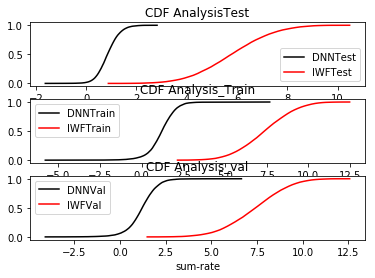

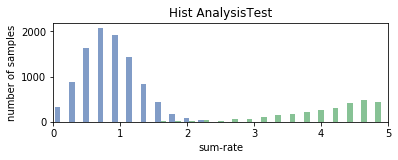

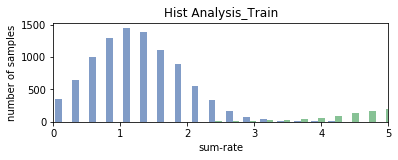

Sum-rate: IWF: 5.790, DNN: 0.865
Ratio: DNN: 14.935%

Sum-rate: IWF: 7.363, DNN: 1.187
Ratio: DNN: 16.122%



0

In [11]:
import time
model_location = "./DNNtest/model_demo.ckpt"
save_name="./DNNtest/Prediction_Dnn3_10000"

testPerformance(model_location, save_name, 24, 24,12, 2, 2, 3,10000)

INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt


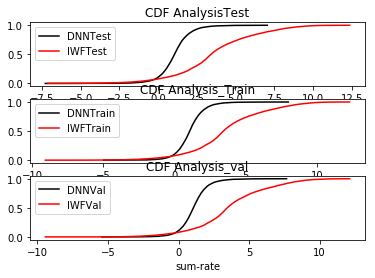

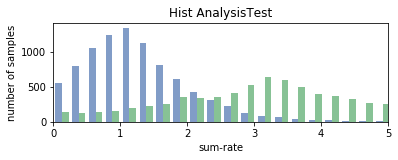

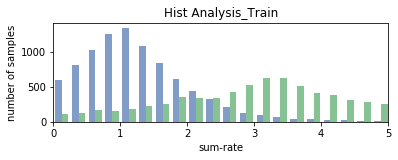

Sum-rate: IWF: 3.631, DNN: 1.080
Ratio: DNN: 29.755%

Sum-rate: IWF: 3.629, DNN: 1.079
Ratio: DNN: 29.735%



0

In [39]:
import time
model_location = "./DNNtest/model_demo.ckpt"
save_name="./DNNtest/Prediction_Dnn3_10000"

testPerformance(model_location, save_name, 24, 24,12, 2, 2, 3,10000)

INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNNtest/model_demo.ckpt


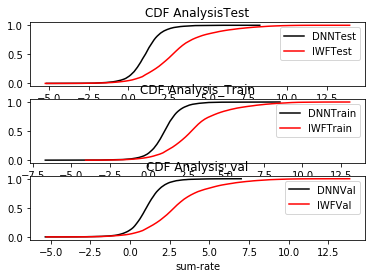

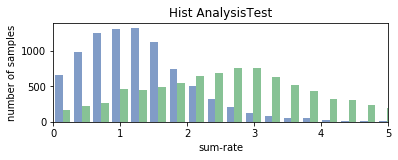

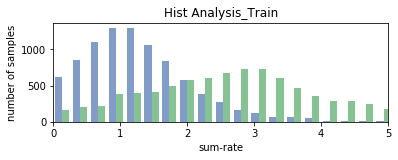

Sum-rate: IWF: 3.021, DNN: 1.056
Ratio: DNN: 34.960%

Sum-rate: IWF: 3.033, DNN: 1.064
Ratio: DNN: 35.076%



0

In [37]:
import time
model_location = "./DNNtest/model_demo.ckpt"
save_name="./DNNtest/Prediction_Dnn3_10000"

testPerformance(model_location, save_name, 24, 24,12, 2, 2, 3,10000)

In [ ]:
save_name="./DNNtest/Prediction_Dnn3_10000"